<p style="font-family: times, serif; font-size:25pt; font-style:bold; color:black;">
   wrapSWASH-1D
</p>

<p style="font-family: times, Times New Roman; font-size:14pt; font-style:italic; color:black;">
    An easy-to-use Jupyter Notebook to model wave transformation over a shallow cross-shore profile with SWASH 
    <br>
</p>

<span style="font-family: times, Times New Roman; font-size:12pt; color:black;">
SWASH (Simulating WAves till SHore) is intented to be a free-surface, terrain-following, multi-dimensional hydrodynamic simulation model used to predict transformation of surface waves and rapidly varied shallow water flows in coastal waters. It solves the continuity and momentum equations, and optionally the equations for conservative transport of salinity, temperature and suspended load for both noncohesive sediment (e.g. sand) and cohesive sediment (mud, clay, etc.) (Zilema et al. 2008).
</span><br><br>

<span style="font-family: times, Times New Roman; font-size:12pt; color:black;">
The purpose of this notebook is to provide the user a tool to run the open-source numerical model 1D SWASH giving some relevant advice in choosing the basic input. The simplicity of the commands inputs make the notebook suitable for performing different sensitivity analysis. For more information consult the implementation manual that can be found at <a href="http://swash.sourceforge.net/" target="_blank">SWASH home page.</a><br>
<br>
        
<hr size="5"/>

## Table of Contents

* [1. Data preprocessing](#1.)
	* [1.1. Cross-shore profile](#1.1.)
	* [1.2. Friction](#1.2.)     
	* [1.3. Vegetation](#1.3.) 
* [2. Boundary conditions](#2.)
	* [2.1. Sea state generation: JONSWAP spectrum](#2.1.)
	* [2.2. Wind](#2.2.)
* [3. Run](#3.)
* [4. Data Postprocessing](#4.)
	* [4.1. Summary output video](#4.1.)
	* [4.2. Wave propagation video](#4.2.)


In [1]:
# import python libs
import sys
import os
import os.path as op
import glob

# common
import numpy as np
import pandas as pd
import xarray as xr

# dev
sys.path.insert(0, op.join(os.getcwd(),'..'))

# swash wrap module
from wswash.wrap import SwashProject, SwashWrap, SwashInput
from wswash.plots import SwashPlot

from wswash import profiles
from wswash.waves import series_Jonswap, series_regular_monochromatic, series_regular_bichromatic


In [2]:
# activate / deactivate example friction and vegetation
example_friction = False
example_vegetation = False


## 1. Data preprocessing <a name="1."></a>


<span style="font-family: times, Times New Roman; font-size:12pt; color:black;">
    In this section, the computational grid is defined from the bathymetric data and, optionally, wave dissipation characteristics due to the bottom friction or vegetation. The input grids will be considered uniform and rectangular, with the computational grid covering the whole bathymetric region. <br>

In [3]:
# Create the project directory and set the simulation period and grid resolution
p_data = op.abspath(op.join(os.getcwd(),'..', 'data'))

p_proj = op.join(p_data, 'projects')  # swash projects main directory
n_proj = 'notebook_demo'              # project name

# SWASH wrapp
sp = SwashProject(p_proj, n_proj)
sw = SwashWrap(sp)
sm = SwashPlot(sp)


### 1.1. Cross-shore profile <a name="1.1."></a>


<span style="font-family: times, Times New Roman; font-size:12pt; color:black;">
    Model boundaries should be far enough from the area of interest and away from steep topography to avoid unrealistic frictional or numerical dispersion effects but close enough to remain computationally feasible </span> <span style="font-family: times, Times New Roman; font-size:11pt; color:black; background:whitesmoke"> kh < 5. </span> </span> <span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> As a recommendation, the area of interest should be kept at least two wave lengths away from the boundary. In the following cells, different input choices for defining the cross-shore profile will be given. </span>
 
* `dxL`  <span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> : number of nodes per wavelength. This command sets the grid resolution from the number of nodes desired per wavelength in 1m depth (assuming that in the beach due to the infragravigity waves the water colum can reach 1m heigh). </span><br><br>

* `dxinp`: <span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> The resolution of the bathymetric grid is not the same as that of the computational grid. It is advised to avoid extremely steep bottom slopes or sharp obstacles as much as posible. </span>  

#### Load bathymetry from file


<span style="font-family: times, Times New Roman; font-size:12pt; color:black;">
    Land points are defined as negative while wet points are defined as positive.
    </span>

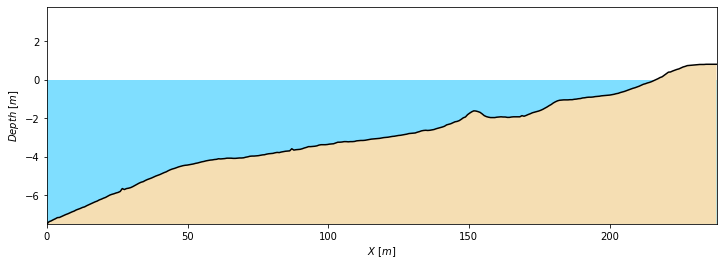

In [4]:
# bathymetry parameters
dxinp = 0.74392  # bathymetry x spacing resolution (m)
dyinp = 1        # bathymetry y spacing resolution (m)

# load depth file
depth = np.loadtxt(op.join(p_data, 'demo', 'depth.bot'))  # depth file path

# set swash project depth
sp.set_depth(depth, dxinp, dyinp)

sm.plot_depthfile();


### 1.2. Friction <a name="1.2."></a>


<p style="font-family: times, Times New Roman; font-size:12pt; color:black;">
With this option the user can activate the bottom friction controlled by the Manning formula. As the friction coefficient may vary over the computational region, the friction data can be read from file or defined by specifyng the start and end point along it is defined the frictional area (e.g. reef). 
    </p>

In [5]:
if example_friction:

    # activate entire bottom friction and set manning coefficient
    sp.friction_bottom = False
    sp.cf = 0.01      # manning frictional coefficient  (m^-1/3 s)

    # use friction file to set friction between two points of the profile
    sp.friction_file = True
    sp.cf_ini = 100   # first point along the profile 
    sp.cf_fin = 200   # last point along the profile 

    # plot updated profile
    sm.plot_depthfile()


### 1.3. Vegetation <a name="1.3."></a>


<p style="font-family: times, Times New Roman; font-size:12pt; color:black;">
With this command the user can activate wave damping induced by aquatic vegetation. The vegetation is included in SWASH as a number of vertical cilinders (rigid plants) defined by the height, diameter and horizontally varying vegetation density.
    </p>

In [6]:
# TODO: repasar comportamiento vegetation file + parametro nstems

if example_vegetation:

    # Define plant shape characteristics and drag coefficient
    sp.vegetation = True
    sp.height =  0.5      # plant height per vertical segment [m] 
    sp.diamtr =  0.5      # diameter of each plant stand per vertical segment [m]
    sp.drag =  0.02       # drag coefficient
    sp.nstems = 100       # nº plants stands per square meter

    # Horizontal vegetation density can be defined by means of a density varying file
    sp.vegetation_file = True
    sp.np_ini = 0               # first point along the profile 
    sp.np_fin = 250             # last point along the profile 

    # plot updated profile
    sm.plot_depthfile()


## 2. Boundary conditions <a name="2."></a>

<p style="font-family: times, Times New Roman; font-size:12pt; color:black;">
    The boundaries of the computational grid in SWASH are either land, beach or water. The wave condition is imposed on the west boundary of the computational domain, so that the wave propagation is pointing eastward. To simulate entering waves without some reflections at the wavemaker boundary, a weakly-reflective boundary condition allowing outgoing waves is adopted. For this test case, a time series synthesized from parametric information (wave height, period, etc.) will be given as wavemaker. This may either be defined as regular waves or irregular unidirectional waves by means of 1D spectrum. Both the initial water level and velocity components are set to zero.
</p>

### 2.1. Sea state generation: JONSWAP spectrum <a name="2.1."></a>


* `tendc`  <span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> : duration of the simulation. The simulation will be long enough to get a steady-state solution. For a suitable simulation time at least 500 to 1000 waves are needed to reach stationary conditions. This time window does not include the spin-up time. It is assumed that the warm up takes at most 15% of the total time of the simulation ($ 0.15 · sp.tendc $). 

In [7]:
# simulation duration parameters

tendc = 1800           # simulation period (SEC)
warmup = 0.15 * tendc  # spin-up time (s) (default 15%)
deltat = 0.5           # delta time over which the wave series is defined (s)


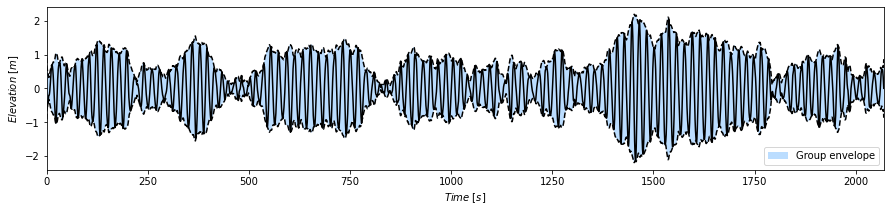

In [8]:
# Define JONSWAP spectrum by means of the following spectral parameters
hs = 3 #1.5     # significant wave height (m)
tp = 19      # peak period (s)
gamma = 100  # peak enhancement parameter of the JONSWAP spectrum
WL = 0       # water level (m)

waves = {
    "WL": WL, 
    "H": hs, 
    "T": tp, 
    "gamma": gamma, 
    "warmup": warmup,
    "tendc": tendc,
    "deltat": deltat,
}

# make waves series dataset
series = series_Jonswap(waves)

# plot series
sm.plot_waves(waves, series)      


### 2.2. Wind <a name="2.2."></a>

<p style="font-family: times, Times New Roman; font-size:12pt; color:black;"> 
The user can optionally specify wind speed, direction and wind drag assuming constant values in the domain. As the test case is using cartesian coordinates, please set the direction where the wind cames from.
</p>

In [9]:
# Define wind parameters
Vel = 14        # wind speed  at 10 m height (m/s)
Wdir = 0        # wind direction at 10 m height (º)
Ca = 0.0026     # dimensionless coefficient (default 0.002)

wind = {
    "wdir": Wdir,
    "vx": Vel, 
    "Ca": Ca, 
}


### 3. Run <a name="3."></a>


<span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> 
In the following, a series of predefined options have been choosen: <br></span>

* <span style="font-family: times, Times New Roman; font-size:12pt; color:black;font-weight:bold; background:ivory;">Grid resolution</span> <span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> is determined through a number of points per wavelength criteria: Courant number for numerical stability, number of points per wavelength, and manual upper and lower limits for grid cell sizes.<br></span>

* <span style="font-family: times, Times New Roman; font-size:12pt; color:black;">The default value for the maximun </span><span style="font-family: times, Times New Roman; font-size:12pt; color:black; background:ivory; font-style:italic; font-weight:bold;">wave breaking steepness</span> <span style="font-family: times, Times New Roman; font-size:12pt; color:black;">parameter is $ \alpha = 0.6$<br></span>

* <span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> For high, nonlinear waves, or wave interaction with structures with steep slopes (e.g. jetties, quays), a Courant number of 0.5 is advised. Here, a dynamically adjusted </span><span style="font-family: times, Times New Roman;  color:black; font-size:12pt; background:ivory; font-weight:bold;">time step</span> <span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> controlled by a Courant number range of (0.1 - 0.5) is implemented<br></span>


<span style="font-family: times, Times New Roman; font-size:12pt; color:black;">
User parametes:<br></span>

* `non_hydrostatic`  <span style="font-family: times, Times New Roman; font-size:12pt; color:black;">to include the non-hydrostatic pressure in the shallow water equations. Hydrostatic pressure assumption can be made in case of propagation of long waves, such as large-scale ocean circulations, tides and storm surges. This assumption does not hold in case of propagation of short waves, flows over a steep bottom, unstable stratified flows, and other small-scale applications where vertical acceleration is dominant </span>
* `vert`  <span style="font-family: times, Times New Roman; font-size:12pt; color:black;">this command set the number of vertical layers in case that the run will be in multi-layered mode </span><br><br>


In [10]:
# swash wrap configuration
sp.non_hydrostatic = True  # True or False
sp.vert = 1               # vertical layers
sp.delttbl = 1            # time between output fields (s)
sp.dxL = 30               # nº nodes per wavelength

# case 0 - waves
si_0 = SwashInput()
si_0.waves_parameters = waves
si_0.waves_series = series


# case 1 - waves and winds
si_1 = SwashInput()
si_1.waves_parameters = waves
si_1.waves_series = series
si_1.wind = wind

# build swash cases
waves = sw.build_cases([si_0, si_1])


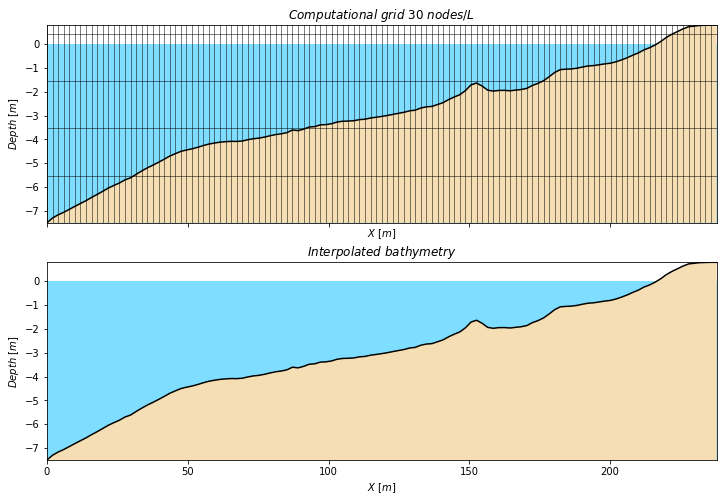

In [11]:
# Run to see the computational grid and bathymetry interpolated
sm.plot_computational(si_0.c_grid.dx)


In [12]:
# Show the 'input.sws' file to check input grids, numerics, physis and output quantities
sw.io.print_input(case_ix=0)


$Project name
PROJECT 'notebook_demo' '0000'
$
$Set water level
SET LEVEL=0
$
$(1D-mode, flume) or (2D-mode, basin)
MODE DYNanic ONED
COORD CARTesian
$Computational grid: geographic location, size, resolution and orientation
CGRID 0 0 0 238 0 161 0
$
$Multi-layered mode
VERT 1
$
$Reading bathymetry values from file
INPGRID BOTTOM 0 0 0 320 0 0.74 1
READINP BOTTOM 1 'depth.bot' 1 0 FREE
$
$Initial values for flow variables
INIT ZERO
$
$Hydraulic boundary conditions
BOU SIDE W CCW BTYPE WEAK CON SERIES 'waves.bnd'
BOU SIDE E CCW BTYPE RADIATION 
SPON E 10 
$
$Physics
BREAK
$Numerics
NONHYDrostatic
$
$Output quantities
DISCRET UPW MOM
DISCRET UPW UMOM H NONE
DISCRET UPW WMOM H NONE
DISCRET CORR
$
$Time integration
TIMEI 0.1 0.5
$
QUANTITY XP hexp=10
QUANT RUNUP delrp 0.01
$
CURVE 'line' 0 0 238 238 0
TABLE 'line' HEAD 'output.tab' TSEC XP YP BOTL WATL QMAG OUTPUT 0 1 SEC
$
TABLE 'NOGRID' HEAD 'run.tab' TSEC RUNUP OUTPUT 0 1 SEC
$
$Starts computation
TEST  1,0
COMPUTE 000000.000 0.0582 SEC

In [13]:
# Run cases
sw.run_cases()


SWASH CASE: 0000 SOLVED
SWASH CASE: 0001 SOLVED


### 4. Data Postprocessing <a name="4."></a>

<span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> 
    Different output quantities will be given here to go over the different wave transformation processes including wave propagation, dispersion, flooding and drying, moving shoreline, surf-beat, infragravity waves, set-up induced by wave breaking, run-up and overtopping discharge. <br><br>

<span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> 
    To this end, the time-dependent <span style="font-family: times, Times New Roman; font-weight:bold; font-size:12pt; color:black; background:ivory"> surface elevation </span> is stored at every grid point for every time step. After removing the warmup time from the sea surface series, a FFt is applied to obtain its representation in the frequency domain. A further classification is given by spliting the wave frequency into incident waves IC (0.04 - 1), infragravity waves IG (0.004 - 0.04) and very low frequency VLF (0.001 - 0.004). </span><br><br>

    
<span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> 
    The <span style="font-family: times, Times New Roman; font-size:12pt; color:black;font-weight:bold; background:ivory">run-up heigh </span> is computed by the intersection between free surface and bottom level considering a minimun  depth of 1cm after each time step. </span><br><br>

<span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> 
    The <span style="font-family: times, Times New Roman; font-size:12pt; color:black;font-weight:bold; background:ivory"> mean wave overtopping discharge </span> q (ms/l) is outputted at the highest elevation point.
</span> <br><br>

In [14]:
# postprocess case output
output_post = sw.postprocessing(case_ix=0)


#### **4.1 Summary output video**

<span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> 
    Under the idealised shallow-water conditions considered here, the wave spectrum evolves essentially as in deep water: from the high frequencies to lower frequencies while the area under the spectrum increases (and therefore also the significant wave height). In order to analyze the wave transformation processes along the cross-shore profile, a number of wave gates have been choseen to record the numerical results. Here bellow, the figures created in the previous step tend to synthesize the different output quantities. </span><br>

In [15]:
from IPython.display import Video

# output video
p_vid = sw.video_summary_output(case_ix=0)

Video(p_vid, embed=True)


#### **4.2 Wave propagation video**

<span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> 
    Finally, another video shows the waves propagating and reaching the coastline. Visualizing the wave breaking line and wave steepness may be useful to evaluate the quality of the previously selected inputs.
</span><br>

In [16]:
from IPython.display import Video

# output video
p_vid = sw.video_waves_propagation(case_ix=0)

Video(p_vid, embed=True)


<br><br>